In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
print(tf.test.is_gpu_available)

<function is_gpu_available at 0x000001B6549010D0>


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import os

In [5]:
print(os.getcwd())

C:\Users\Randy\GitHub\metamo


In [6]:
train_root = os.path.join(os.getcwd(),'train')
test_root = os.path.join(os.getcwd(),'test')
emotions = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [7]:
for emotion in emotions:
    f_name = os.listdir(os.path.join(train_root,emotion))
    print(emotion , ' has \t', len(f_name), ' number of files')

angry  has 	 3995  number of files
disgust  has 	 436  number of files
fear  has 	 4097  number of files
happy  has 	 7215  number of files
neutral  has 	 4965  number of files
sad  has 	 4830  number of files
surprise  has 	 3171  number of files


In [8]:
seed_num = 42

train_dataGen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                               vertical_flip = True)

train_dataflow = train_dataGen.flow_from_directory(train_root,
                                                  target_size = (48,48),
                                                  color_mode = 'grayscale',
                                                  seed = seed_num)

test_dataGen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_dataflow = test_dataGen.flow_from_directory(test_root,
                                                target_size=(48,48),
                                                color_mode= 'grayscale',
                                                shuffle = False,
                                                seed = seed_num)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
CNN_v1_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3) , input_shape = (48,48,1), activation = 'relu'),
    tf.keras.layers.Conv2D(128, (3,3) , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3) , activation = 'relu'),
    tf.keras.layers.Conv2D(512, (3,3) , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [10]:
CNN_v1_model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.RMSprop())

In [11]:
CNN_v1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 44, 44, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 256)       2

In [12]:
desired_acc = 0.95

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if (log['acc'] > desired_acc):
            print('\n Accuracy has reached desired accuracy of ', desired_acc, ' stopping training')
            self.model.self_training = True
            
myCallback = myCallback()

In [13]:
early_callback = tf.keras.callbacks.EarlyStopping(patience=50, 
                                                  restore_best_weights= True)

In [14]:
CNN_v1_model.load_weights('CNN_v1_250epochs.h5')
# epochs = 10
# steps_per_epoch = 1000

# CNN_v1_history = CNN_v1_model.fit(train_dataflow, 
#                                   epochs = epochs, 
#                                   validation_data=(test_dataflow),
#                                   #steps_per_epoch=steps_per_epoch,
#                                   callbacks=[early_callback, myCallback])

In [15]:
def plot_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc  =history.history['val_acc']
    
    length = range(len(loss))
    
    plt.plot(length, loss, 'b' ,label = 'Training Loss')
    plt.plot(length, val_loss, 'r--', label = 'Validation Loss')
    plt.title('Training vs Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure()
    
    plt.plot(length, acc, 'b' ,label = 'Training Acc')
    plt.plot(length, val_acc, 'r--', label = 'Validation Acc')
    plt.title('Training vs Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_results(CNN_v1_history)

This looks promising. We train for a further 90 epochs, totalling 100 epochs for this model

epochs = 100
steps_per_epoch = 1000

CNN_v1_history = CNN_v1_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  initial_epoch = 10,
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback])

plot_results(CNN_v1_history)

CNN_v1_model.save('CNN_v1_250epochs.h5')

In [16]:
from sklearn.metrics import classification_report

In [17]:
predictions = CNN_v1_model.predict(test_dataflow)

In [18]:
predictions = np.argmax(predictions, axis = -1)

In [19]:
y_test = test_dataflow.labels

In [20]:
print(classification_report(y_test, predictions, target_names = emotions))

              precision    recall  f1-score   support

       angry       0.36      0.48      0.41       958
     disgust       0.00      0.00      0.00       111
        fear       0.37      0.12      0.18      1024
       happy       0.67      0.83      0.74      1774
     neutral       0.45      0.58      0.51      1233
         sad       0.43      0.31      0.36      1247
    surprise       0.66      0.71      0.68       831

    accuracy                           0.52      7178
   macro avg       0.42      0.43      0.41      7178
weighted avg       0.49      0.52      0.49      7178



C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
def pull_random_test_image():
    random_int = np.random.choice(6,1)
    random_emotion = emotion[random_int]
    random_folder = os.path.join(test_root, random_emotion)
    

# Transfer Learning

In [22]:
Incep_model = tf.keras.applications.InceptionV3(include_top=False)

In [23]:
Incep_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_4 (Conv2D)              (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_2 (BatchNo  (None, None, None,   96         ['conv2d_4[0][0]']               
 rmalization)                   32)                                                    

In [24]:
for layers in Incep_model.layers:
    layers.trainable = False

In [25]:
last_layer = Incep_model.get_layer('conv2d_55')

In [26]:
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, None, None, 160)


In [27]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(7, activation = 'softmax')(x)

In [28]:
tl_Incept_model = tf.keras.models.Model(Incep_model.input, x)

In [29]:
tl_Incept_model.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]

In [30]:
tl_Incept_model.outputs

[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_3')>]

In [31]:
tl_Incept_model.compile(loss = 'categorical_crossentropy' , 
                        metrics = ['acc'],
                        optimizer = tf.keras.optimizers.RMSprop())

In [32]:
seed_num = 42

train_dataGen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                               vertical_flip = True)

train_dataflow = train_dataGen.flow_from_directory(train_root,
                                                  target_size = (48,48),
                                                  color_mode = 'grayscale',
                                                  seed = seed_num)

test_dataGen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_dataflow = test_dataGen.flow_from_directory(test_root,
                                                target_size=(48,48),
                                                color_mode= 'grayscale',
                                                shuffle = False,
                                                seed = seed_num)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [33]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [34]:
train_rgb_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                    preprocessing_function= to_grayscale_then_rgb ,
                                                                   #preprocessing_function=tf.image.grayscale_to_rgb,
                                                                   vertical_flip= True)

train_dataflow_rgb = train_rgb_datagen.flow_from_directory(train_root,
                                                          target_size = (48,48,),
                                                          seed = seed_num)

test_rgb_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                   preprocessing_function= to_grayscale_then_rgb,
                                                                   #preprocessing_function=tf.image.grayscale_to_rgb,
                                                                   vertical_flip= True)

test_dataflow_rgb = test_rgb_datagen.flow_from_directory(test_root,
                                                          target_size = (48,48,),
                                                         shuffle = False,
                                                          seed = seed_num)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [35]:
epochs = 50
steps_per_epoch = 1000

tl_Incept_history = tl_Incept_model.fit(train_dataflow_rgb,
                                          epochs = epochs, 
                                          validation_data=(test_dataflow_rgb),
                                          #steps_per_epoch=steps_per_epoch,
                                          callbacks=[early_callback, myCallback])

Epoch 1/50
898/898 [==============================] - 133s 145ms/step - loss: 1.7101 - acc: 0.3298 - val_loss: 1.6017 - val_acc: 0.3711
Epoch 2/50
898/898 [==============================] - 132s 147ms/step - loss: 1.6231 - acc: 0.3667 - val_loss: 1.5686 - val_acc: 0.3777
Epoch 3/50
898/898 [==============================] - 132s 147ms/step - loss: 1.6008 - acc: 0.3759 - val_loss: 1.5793 - val_acc: 0.3791
Epoch 4/50
898/898 [==============================] - 148s 165ms/step - loss: 1.5904 - acc: 0.3816 - val_loss: 1.5740 - val_acc: 0.3746
Epoch 5/50
898/898 [==============================] - 139s 155ms/step - loss: 1.5851 - acc: 0.3866 - val_loss: 1.5834 - val_acc: 0.3768
Epoch 6/50
898/898 [==============================] - 122s 136ms/step - loss: 1.5861 - acc: 0.3865 - val_loss: 1.5617 - val_acc: 0.3979
Epoch 7/50
898/898 [==============================] - 132s 147ms/step - loss: 1.5782 - acc: 0.3899 - val_loss: 1.5740 - val_acc: 0.3948
Epoch 8/50
898/898 [============================

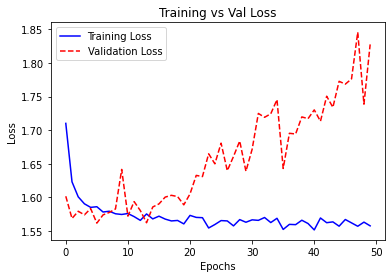

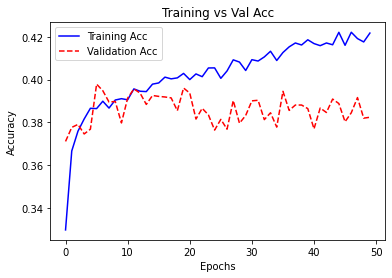

In [36]:
plot_results(tl_Incept_history)

In [37]:
tl_Incept_model.save('tl_Incept_model_epochs50.h5')

In [38]:
predictions = tl_Incept_model.predict(test_dataflow_rgb)

In [39]:
predictions = np.argmax(predictions, axis = -1)

In [40]:
y_test = test_dataflow_rgb.labels

In [41]:
print(classification_report(y_test, predictions, target_names = emotions))

              precision    recall  f1-score   support

       angry       0.26      0.22      0.24       958
     disgust       0.12      0.01      0.02       111
        fear       0.24      0.15      0.19      1024
       happy       0.44      0.70      0.54      1774
     neutral       0.39      0.29      0.33      1233
         sad       0.33      0.31      0.32      1247
    surprise       0.53      0.52      0.53       831

    accuracy                           0.39      7178
   macro avg       0.33      0.31      0.31      7178
weighted avg       0.36      0.39      0.36      7178



# ResNet

In [50]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top= False)

In [51]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [53]:
for layer in resnet.layers:
    layer.trainable = False

In [57]:
inputs = resnet.input

In [59]:
last_layer = resnet.get_layer('conv5_block1_out')
last_output = last_layer.output
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(7, activation = 'softmax')(x)

tf_resnet_model = tf.keras.models.Model(inputs, x)

In [60]:
tf_resnet_model.compile(loss = 'categorical_crossentropy' , 
                        metrics = ['acc'],
                        optimizer = tf.keras.optimizers.RMSprop())

In [ ]:
epochs = 50
steps_per_epoch = 1000

tf_resnet_history = tf_resnet_model.fit(train_dataflow_rgb, 
                                          epochs = epochs, 
                                          validation_data=(test_dataflow_rgb),
                                          #steps_per_epoch=steps_per_epoch,
                                          callbacks=[early_callback, myCallback])

Epoch 1/50
898/898 [==============================] - 122s 132ms/step - loss: 2.0285 - acc: 0.2278 - val_loss: 1.8218 - val_acc: 0.2471
Epoch 2/50
898/898 [==============================] - 106s 118ms/step - loss: 1.8072 - acc: 0.2499 - val_loss: 1.8002 - val_acc: 0.2471
Epoch 3/50
898/898 [==============================] - 109s 121ms/step - loss: 1.7982 - acc: 0.2548 - val_loss: 1.7850 - val_acc: 0.2520
Epoch 4/50
898/898 [==============================] - 113s 125ms/step - loss: 1.7918 - acc: 0.2573 - val_loss: 1.7875 - val_acc: 0.2491
Epoch 5/50
898/898 [==============================] - 109s 121ms/step - loss: 1.7875 - acc: 0.2574 - val_loss: 1.7759 - val_acc: 0.2797
Epoch 6/50
898/898 [==============================] - 112s 124ms/step - loss: 1.7837 - acc: 0.2609 - val_loss: 1.7671 - val_acc: 0.2633
Epoch 7/50
898/898 [==============================] - 154s 171ms/step - loss: 1.7797 - acc: 0.2642 - val_loss: 1.7592 - val_acc: 0.2774
Epoch 8/50
898/898 [============================

In [ ]:
plot_results(tf_resnet_history)

In [ ]:
tf_resnet_model.save('tf_resnet_model_epochs50.h5')

In [ ]:
predictions = tf_resnet_model.predict(test_dataflow_rgb)

In [ ]:
predictions = np.argmax(predictions, axis = -1)

In [ ]:
y_test = test_dataflow_rgb.labels

In [ ]:
print(classification_report(y_test, predictions, target_names = emotions))

# Fine Tunning